Bilayer unit domain. Sigma optimisation

In [222]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [ ]:
# Define element size for the mesh refinement
h_i = [0.125/4,   # N=2
       0.125/8,   # N=3
       0.125/16,] # N=4

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/2
# sigma_0 = 1 #0.484375

# Solver configuration
requested_eigenvalues_number = 50 # Number of eigenvalues to compute


degree=[3,2]  # Polynomial degree for pressure and velocity
sigma_sweep_quadratic=np.linspace(1., 1000., 40)
target=-12.5j


Solver configuration and computing

In [224]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

In [225]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof, normalize_at):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    # --- normalización opcional ---
    if normalize_at is not None:
        p_norm = p_h.eval(normalize_at, 1)
        v_norm = v_h.eval(normalize_at, 1)
        if abs(p_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de p.")
        if abs(v_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de v.")

        p_h.x.array[:] /= p_norm
        v_h.x.array[:] /= v_norm
    return p_h, v_h

In [226]:
def get_exact_eigenpair(solver, selected_index, Q, V, x_hat, sigma_x, gamma_x, normalize_at):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    # sigma_x = lambda x: np.where(x[0] >= l_inner, sigma_0, 0)
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    # --- normalización opcional ---
    if normalize_at is not None:
        p_norm = p_ex.eval(normalize_at, 1)
        v_norm = v_ex.eval(normalize_at, 1)
        if abs(p_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de p.")
        if abs(v_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de v.")
        p_ex.x.petsc_vec.array[:] /= p_norm
        v_ex.x.petsc_vec.array[:] /= v_norm

    return [w, p_ex, v_ex]

In [227]:
def get_function_plot_data(u):
    """
    Devolve (x_sorted, values_sorted) listos para plt.plot.

    Funciona en mallas 1D en dolfinx 0.9.
    Usa coordenadas dos DOFs do espazo de u.
    """

    V = u.function_space
    mesh = V.mesh

    # Coordenadas dos DOFs
    X = V.tabulate_dof_coordinates().copy()

    # COLAPSAR dimensións sobrantes: quedamos coa coordenada x
    if X.shape[1] > 1:
        X = X[:, 0]

    # Obter valores da función
    try:
        vals = u.x.array.copy()
    except AttributeError:
        vals = u.vector.getArray().copy()

    # Ordenar por coordenada x
    idx = np.argsort(X)
    return X[idx], vals[idx]


In [228]:
def project_exact_to_mesh(u_exact, Vh):
    """
    Proxecta/interpola unha expresión exacta (UFL) ou un Function
    doutra malla ao espazo funcional Vh (malla actual).

    Funciona en dolfinx 0.9 e evita todos os problemas de dimensión
    e de Expression nos MixedElements.
    """

    # Se u_exact xa é un Function no mesmo espazo, devolver directamente
    if isinstance(u_exact, Function) and u_exact.function_space == Vh:
        return u_exact

    # Crear Function sobre Vh
    u_proj = Function(Vh)

    # Caso 1: exacta é Function doutra malla -> interpolar
    if isinstance(u_exact, Function):
        u_proj.interpolate(u_exact)
        return u_proj

    # Caso 2: exacta é UFL Expression -> interpolar mediante Expression
    # Obter puntos de interpolación (DOF coordinates)
    X = Vh.tabulate_dof_coordinates()

    # Se é 1D pero X ven con máis dimensións, quedar coa primeira columna
    if X.ndim == 2 and X.shape[1] > 1:
        X = X[:, :1]

    expr = Expression(u_exact, X, dtype=u_proj.x.array.dtype)
    u_proj.interpolate(expr)

    return u_proj


In [229]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    tdim = mesh.topology.dim

    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        lambda x: np.logical_and(x[0] >= 0, x[0] <= Lx)
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)

    # --- 2) Alinear fase só na zona física ---
    inner_num_exact = assemble_scalar(form(inner(u_num, u_exact) * dx_phys(1)))
    inner_exact_exact = assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1)))

    c = inner_num_exact / inner_exact_exact

    u_aligned = u_num.copy()
    u_aligned.x.array[:] = u_num.x.array[:] / c

    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_aligned - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [ ]:
def get_closest_approx_eigenpair(solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    exact_eigenvalues = [None] * 5 # Almacena los autovalores exactos
    p_exact = [None] * 5  # Almacena los autovectores exactos de presión
    v_exact = [None] * 5  # Almacena los autovectores exactos de velocidad
    p_approx = [None] * 5  # Almacena los autovectores exactos de presión
    v_approx = [None] * 5  # Almacena los autovectores exactos de velocidad
    best_0 = None
    best_3 = None

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()

    x_hat_quadratic=lambda x, w: (x[0]+ (np.abs(x[0]) > Lx)* np.sign(x[0])* 1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2))
    sigma_quadratic_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
    gamma_x_quadratic = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)

    [exact_eigenvalues[0], p_exact[0], v_exact[0]] =   get_exact_eigenpair(solver, 1, Q, V, x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic, [Lx, 0, 0])
    [exact_eigenvalues[3], p_exact[3], v_exact[3]] =   get_exact_eigenpair(solver, 4, Q, V, x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic, [Lx, 0, 0])

    for k in range(nconv):
        approx_eigenvalue = solver.getEigenvalue(k) * 1j 
        solver.getEigenpair(k, vrA)  
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof, normalize_at = [Lx, 0, 0])

        # --- autovalores ---
        err_eig_0 = abs(approx_eigenvalue - exact_eigenvalues[0]) / abs(exact_eigenvalues[0])
        err_eig_3 = abs(approx_eigenvalue - exact_eigenvalues[3]) / abs(exact_eigenvalues[3])

        # --- autovectores ---
        err_p_0 = eigenvector_L2_error_physical(p_h, p_exact[0], Lx, mesh)
        err_v_0 = eigenvector_L2_error_physical(v_h, v_exact[0], Lx, mesh)

        err_p_3 = eigenvector_L2_error_physical(p_h, p_exact[3], Lx, mesh)
        err_v_3 = eigenvector_L2_error_physical(v_h, v_exact[3], Lx, mesh)

        # Total
        err_0 = err_eig_0 + err_p_0 + err_v_0
        err_3 = err_eig_3 + err_p_3 + err_v_3

        if best_0 is None or err_0 < best_0[2]:
            best_0 = (approx_eigenvalue, k, err_0)

        if best_3 is None or err_3 < best_3[2]:
            best_3 = (approx_eigenvalue, k, err_3)

    closest_eig_0, idx_best_0, rel_err_best_0 = best_0
    closest_eig_3, idx_best_3, rel_err_best_3 = best_3

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA_0, vi_0 = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best_0, vrA_0)
    [p_approx[0], v_approx[0]]=assign_eigenvector_to_functions(vrA = vrA_0, p_h = p_h, v_h = v_h, dof = dof, normalize_at = [Lx, 0, 0])
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA_3, vi_3 = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best_3, vrA_3)
    [p_approx[3], v_approx[3]]=assign_eigenvector_to_functions(vrA = vrA_3, p_h = p_h, v_h = v_h, dof = dof, normalize_at = [Lx, 0, 0])


    if verbose:
        print(f"$[Closest] idx={idx_best_0}  \omega={closest_eig_0}  \epsilon_r={rel_err_best_0}$")
        print(f"$[Closest] idx={idx_best_3}  \omega={closest_eig_3}  \epsilon_r={rel_err_best_3}$")


    if plot:
        
        fig, axes = plt.subplots(2, 2, figsize=(12,8))

        # ============================================================
        #  FILA 1 — AUTOVECTORES p
        # ============================================================

        # --- p, modo 0 ---
        ax = axes[0, 0]

        u_ex_proj_0 = project_exact_to_mesh(p_exact[0], p_approx[0].function_space)
        x_num_0, y_num_0 = get_function_plot_data(p_approx[0])
        x_ex_0,  y_ex_0  = get_function_plot_data(u_ex_proj_0)

        mask_0 = x_ex_0 < 1

        ax.plot(x_ex_0[mask_0], np.real(y_ex_0[mask_0]), label="exact", linestyle="solid")
        ax.plot(x_num_0[mask_0], np.real(y_num_0[mask_0]), label="quadratic", linestyle="-.")
        ax.set_xlabel("x")
        ax.set_ylabel("$p(x)$")
        ax.set_title("Eigenvector p — mode 0")
        ax.grid(True)
        ax.legend()

        # --- p, modo 3 ---
        ax = axes[0, 1]

        u_ex_proj_3 = project_exact_to_mesh(p_exact[3], p_approx[3].function_space)
        x_num_3, y_num_3 = get_function_plot_data(p_approx[3])
        x_ex_3,  y_ex_3  = get_function_plot_data(u_ex_proj_3)

        mask_3 = x_ex_3 < 1

        ax.plot(x_ex_3[mask_3], np.real(y_ex_3[mask_3]), label="exact", linestyle="solid")
        ax.plot(x_num_3[mask_3], np.real(y_num_3[mask_3]), label="quadratic", linestyle="-.")
        ax.set_xlabel("x")
        ax.set_ylabel("$p(x)$")
        ax.set_title("Eigenvector p — mode 3")
        ax.grid(True)
        ax.legend()

        # ============================================================
        #  FILA 2 — AUTOVECTORES v
        # ============================================================

        # --- v, modo 0 ---
        ax = axes[1, 0]

        v_ex_proj_0 = project_exact_to_mesh(v_exact[0], v_approx[0].function_space)
        x_num_v0, y_num_v0 = get_function_plot_data(v_approx[0])
        x_ex_v0,  y_ex_v0  = get_function_plot_data(v_ex_proj_0)

        mask_v0 = x_ex_v0 < 1

        ax.plot(x_ex_v0[mask_v0], np.real(y_ex_v0[mask_v0]), label="exact", linestyle="solid")
        ax.plot(x_num_v0[mask_v0], np.real(y_num_v0[mask_v0]), label="quadratic", linestyle="-.")
        ax.set_xlabel("x")
        ax.set_ylabel("$v(x)$")
        ax.set_title("Eigenvector v — mode 0")
        ax.grid(True)
        ax.legend()

        # --- v, modo 3 ---
        ax = axes[1, 1]

        v_ex_proj_3 = project_exact_to_mesh(v_exact[3], v_approx[3].function_space)
        x_num_v3, y_num_v3 = get_function_plot_data(v_approx[3])
        x_ex_v3,  y_ex_v3  = get_function_plot_data(v_ex_proj_3)

        mask_v3 = x_ex_v3 < 1

        ax.plot(x_ex_v3[mask_v3], np.real(y_ex_v3[mask_v3]), label="exact", linestyle="solid")
        ax.plot(x_num_v3[mask_v3], np.real(y_num_v3[mask_v3]), label="quadratic", linestyle="-.")
        ax.set_xlabel("x")
        ax.set_ylabel("$v(x)$")
        ax.set_title("Eigenvector v — mode 3")
        ax.grid(True)
        ax.legend()

        plt.tight_layout()
        plt.show()


    return closest_eig_0, p_approx[0], v_approx[0], rel_err_best_0, closest_eig_3, p_approx[3], v_approx[3], rel_err_best_3


In [ ]:
# Diccionarios onde gardar os erros para cada refinamento N
rel_err_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
approx_omega  = {0: {}, 3: {}}
approx_p      = {0: {}, 3: {}}
approx_v      = {0: {}, 3: {}}

# Iterar sobre N = 0,1,2 → corresponde a h_i[0], h_i[1], h_i[2]
for N, h in enumerate(h_i):

    print(f"\n=== Executando para N = {N+2}, h = {h} ===")

    # Inicializar listas baleiras para este N
    rel_err_sigma_sweep[0][N] = []
    rel_err_sigma_sweep[3][N] = []

    approx_omega[0][N] = []
    approx_omega[3][N] = []

    approx_p[0][N] = []
    approx_p[3][N] = []

    approx_v[0][N] = []
    approx_v[3][N] = []

    # Crear nova malla para este refinamento
    mesh = create_interval(
        MPI.COMM_WORLD,
        int((Lx + pml_thickness) / h),
        [0, Lx + pml_thickness]
    )

    # Percorrer sigma_sweep_quadratic
    for i, sigma_i in enumerate(sigma_sweep_quadratic):

        sigma_quadratic_ufl=lambda x: conditional(x[0] > Lx, sigma_i*(x[0]-Lx)**2/(pml_thickness**2), 0.0)


        solver_quadratic, mesh, Q_, V_, dof_ = get_configured_problem(
            mesh, degree, sigma_quadratic_ufl
        )

        (
            eig0, p0, v0, err0,
            eig3, p3, v3, err3
        ) = get_closest_approx_eigenpair(
            solver_quadratic, Q_, V_, dof_, sigma_i, mesh,
            verbose=False, plot=False
        )

        # Gardar resultados
        approx_omega[0][N].append(eig0)
        approx_omega[3][N].append(eig3)

        approx_p[0][N].append(p0)
        approx_p[3][N].append(p3)

        approx_v[0][N].append(v0)
        approx_v[3][N].append(v3)

        rel_err_sigma_sweep[0][N].append(err0)
        rel_err_sigma_sweep[3][N].append(err3)



=== Executando para N = 2, h = 0.03125 ===


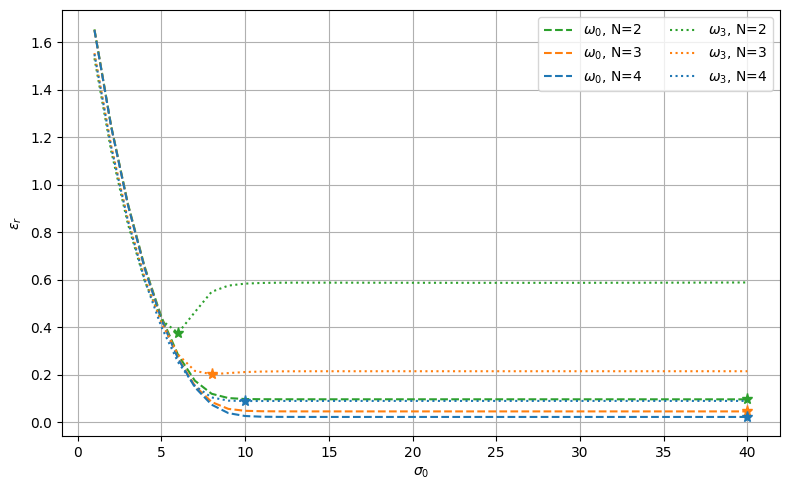

In [ ]:
import matplotlib.pyplot as plt

colors = ['tab:green', 'tab:orange', 'tab:blue']  
linestyles = {0: '--', 3: ':'}
labels = {0: r'$\omega_0$', 3: r'$\omega_3$'}

plt.figure(figsize=(8,5))

# ITERAR SOBRE OS INDICES REAIS: 0,1,2
for j in [0,3]:  # modos físicos


    

    for N_index in range(len(h_i)):   # N_index = 0,1,2
        plot_N = N_index + 2          # para etiquetas: 2,3,4
        col = colors[N_index]

        errs = rel_err_sigma_sweep[j][N_index]
        ls = linestyles[j]

        # curva
        plt.plot(
            sigma_sweep_quadratic,
            errs,
            color=col,
            linestyle=ls,
            label=f"{labels[j]}, N={plot_N}"
        )

        # mínimo
        k = np.argmin(errs)
        plt.plot(
            sigma_sweep_quadratic[k],
            errs[k],
            '*',
            color=col,
            markersize=8
        )

plt.xlabel(r'$\sigma_0$')
plt.ylabel(r'$\epsilon_r$')
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()
